In [1]:
from extract_features import process_dataset, load_and_process_sample
from visualization import signal_viewer
from imu_pipeline import IMUPipeline
from pathlib import Path
import pandas as pd
import joblib
import os
import pandas as pd

import numpy as np

In [2]:
signal_viewer(
    data_dir=Path('data/raw/train'),
    labels_csv=Path('data/train.csv')
)

# ❓ Questions to Reflect On


- What do you observe when comparing the model’s predictions on the new data to its known performance?

- Is there anything in the data that might explain differences in behavior?

- Can you identify patterns or trends related to when the model succeeds or fails?

- Are there signals or features that seem to affect the model’s reliability?

- What could be done in the short term to handle the current situation?

- What are potential long-term steps to improve model performance in similar scenarios?

- What would you want to explore further if given more time or data?

- What assumptions did the model rely on during training — and are they still valid?

# Analysis of test data vs. inference data #
### note: I used chatGPT to understand what the columns are, as I couldn't find a description of the columns in the task. So if a column is misinterpreted that's a context-availability problem as I am unfamliar with this data. ###


### Main Finding ###
Seems the performance difference between the inference and test data, is that the driver-vehicle metadata for inference data is somehow mangled. The clearest way to see this to look at features that should remain consistent for a vehicle across different lines in the data - device_model, calibration_status, firmware_version, sensor_source, network_type.
For example, when filtering  for driver_id=D1071 in both datasets on these features and deduping,you can see that in the inference dataset for example the SUV and sedan have different models, different firmware vesions, different network types, while the same filter from the test data provides exactly one row for each vehicle, and each vehicle has exactly one sensor source, firmware version, etc as expected. 

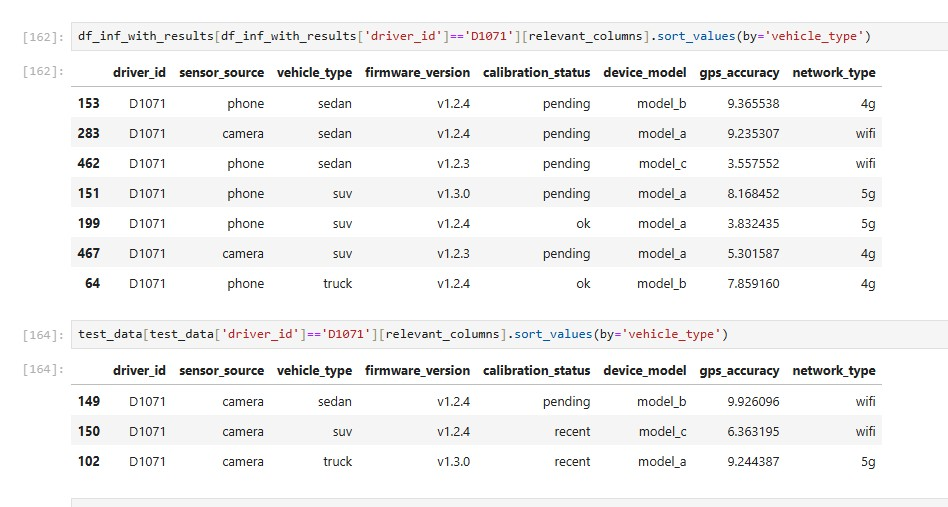

In [6]:
from IPython.display import Image

# Specify the image path (it could be a local file or a URL)
Image(filename='screenshot.jpg')

My best guess and intuition here is that something went wrong with this data in the pipeline or it arrived corrupted in the pipeline. I don't have access to the source of truth data so can't say for sure what's the root cause but those would be my first suspects.

### short term solutions ###
Remove from the training and testing data all rows that arrived in the same batch as the inference table data, flag them as unusable and possibly delete them from the database. There are no overlapping session_ids with the test data so this shouldn't affect the good data.
### Longer term solutions ###
1) Check for these issues in all available data, find the root cause and fix it
2) Add monitoring and validation scripts that catch this kind of inconsistency as it arrives

## EDA summary ##
1) Features that correlate with worse model performance: older firmware versions, time of day being afternoon (suggestion in-between lighting conditions are problematic for the model), SUV vehicle type, fog weather (which is completely expected, it also reduces human performance)
##### Action Item:  Adding afternoon sessions, vehicles with older firmware versions, and SUV vehicles to the training data would probably improve performance. #####
2) More features that correlate with worse model predictions: x_n_peaks, z_skew, z_min, z_mean, z_fft_max, z_energy, yu_fft_max, xz_corr - according to chatGPT these are features relating to vertical movement, sudden de-acceleration, signal peaks that could be caused by vibrations/impacts/events. What I understand from this is that the model doesn't give good predictions on crashes and near-crashes, which is actually one of the top reasons someone might want to get a Nexar Dashcam, so this is hugely problematic.
##### Action Item: train heavily on crash and near-crash events in P1 priority. #####


## Further exploration with more time and data ##
Having more time and data - also more rows and also more features - I'd like to look at performance with the following:
1) Road types - highways, residential streets, dirt roads - different roads mean different movement types.
2) More vehicle context - model+year (for example the small 2006 hyundai i used to have would wobble with high winds in a way I've yet to experience with other cars since), vehicle size class, electric vs. gas cars, etc
3) More info on weather conditions - things like strong wind could potentially affect car movements (at least for 2006 hyundai car i once had)



## Model assumptions ##
I don't know for sure the assumptions in the training data, but guessing from the performance I've seen it seems the assumptions were that a private car is generally smaller than an SUV, driving happens in the morning or at night, and post people have the latest firmware installed. These assumptions don't cover everything and the training data needs to be diversified. 

In [11]:
##Evaluating the model on inference

In [12]:
from extract_features import process_dataset
process_dataset('inference')

[INFO] No label CSV found for 'inference' – proceeding without labels.

Processing 'inference' dataset...


100%|████████████████████████████████████████████████████████████████████████████████| 473/473 [00:12<00:00, 39.20it/s]


Processed 473 samples to data/inference.csv


,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,...,temperature,humidity,altitude,session_id,firmware_version,calibration_status,battery_level,gps_accuracy,network_type,device_model
0,0.058921,0.141937,0.263645,-0.227241,0.490886,-0.411727,-1.269705,17,2.361775,0.016296,...,29,21,383,S910846,v1.2.4,pending,97,5.613430,5g,model_b
1,0.106114,0.269372,1.778952,-0.216834,1.995787,3.211183,15.644389,1,8.382128,0.056256,...,15,58,163,S745147,v1.3.0,pending,60,1.196678,5g,model_b
2,0.789526,2.145882,9.063698,-5.985732,15.049430,0.780326,3.492323,11,522.816335,0.819377,...,32,55,838,S815741,v1.3.0,ok,39,3.882185,wifi,model_b
3,0.608177,1.767987,7.425284,-5.526085,12.951369,0.051386,2.937480,15,349.565584,1.388228,...,24,71,166,S192238,v1.2.3,ok,46,3.886005,wifi,model_b
4,-1.194933,1.703552,5.421388,-5.423952,10.845341,1.637340,4.764184,5,432.995344,-0.195628,...,27,52,720,S146695,v1.2.3,recent,36,7.753421,4g,model_a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,-1.636018,1.836926,6.591974,-9.584012,16.175985,0.312256,7.618219,3,605.085057,1.075774,...,24,75,720,S259109,v1.2.3,ok,76,3.351859,5g,model_b
469,0.060071,0.144546,0.310245,-0.195478,0.505723,-0.337960,-1.312457,13,2.450196,0.015352,...,17,78,945,S852576,v1.2.4,ok,91,6.921099,5g,model_b
470,0.558987,1.950833,8.567100,-4.938564,13.505664,0.908525,4.674787,8,411.821559,-0.130941,...,30,34,574,S639486,v1.2.3,recent,95,8.046290,4g,model_a
471,0.102132,0.273789,1.820321,-0.219719,2.040041,3.268718,16.336809,1,8.539161,0.016576,...,26,23,55,S935107,v1.2.4,ok,76,7.027533,4g,model_a


In [14]:
labels = pd.read_csv("data/manual_annotation/inference_labels.csv")

import joblib
from imu_pipeline import IMUPipeline

df_inf = pd.read_csv("data/inference.csv")
model = joblib.load("models/imu_pipeline.pkl")

preds = model.predict(df_inf)
probs = model.predict_proba(df_inf)

df_inf_with_results = df_inf.merge(labels, how='left', on='sample_id')
df_inf_with_results['predictions']=preds

df_inf_with_results.head()

,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,...,altitude,session_id,firmware_version,calibration_status,battery_level,gps_accuracy,network_type,device_model,label,predictions
0,0.058921,0.141937,0.263645,-0.227241,0.490886,-0.411727,-1.269705,17,2.361775,0.016296,...,383,S910846,v1.2.4,pending,97,5.613430,5g,model_b,normal,normal
1,0.106114,0.269372,1.778952,-0.216834,1.995787,3.211183,15.644389,1,8.382128,0.056256,...,163,S745147,v1.3.0,pending,60,1.196678,5g,model_b,collision,collision
2,0.789526,2.145882,9.063698,-5.985732,15.049430,0.780326,3.492323,11,522.816335,0.819377,...,838,S815741,v1.3.0,ok,39,3.882185,wifi,model_b,normal,collision
3,0.608177,1.767987,7.425284,-5.526085,12.951369,0.051386,2.937480,15,349.565584,1.388228,...,166,S192238,v1.2.3,ok,46,3.886005,wifi,model_b,normal,collision
4,-1.194933,1.703552,5.421388,-5.423952,10.845341,1.637340,4.764184,5,432.995344,-0.195628,...,720,S146695,v1.2.3,recent,36,7.753421,4g,model_a,collision,collision


In [15]:
def add_confusion_label(df, true_col, pred_col, positive_class):
    conditions = [
        (df[pred_col] == positive_class) & (df[true_col] == positive_class),  # TP
        (df[pred_col] == positive_class) & (df[true_col] != positive_class),  # FP
        (df[pred_col] != positive_class) & (df[true_col] != positive_class),  # TN
        (df[pred_col] != positive_class) & (df[true_col] == positive_class)   # FN
    ]
    choices = ['TP', 'FP', 'TN', 'FN']
    df['confusion_label'] = pd.Series(pd.Categorical(np.select(conditions, choices, default='Unknown')))
    return df

df_inf_with_results = add_confusion_label(df_inf_with_results, 'label', 'predictions', positive_class='collision')

In [16]:
from sklearn.metrics import classification_report
y_true = df_inf_with_results["label"]
y_pred = df_inf_with_results["predictions"]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

   collision       0.59      0.96      0.73       236
      normal       0.89      0.33      0.48       237

    accuracy                           0.64       473
   macro avg       0.74      0.65      0.61       473
weighted avg       0.74      0.64      0.61       473



In [17]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred)
accuracy

0.6448202959830867

Model evaluation on inference data: there's a very low accuracy of 64%, for collision we have a low precision (0.59) meaning a lot of normal events are classified as colliisions. Recall is 96% which is good (but not sure it's good enough when we're talking about collisions, I think for these cases we want to be at 99% if possible).
For Normal instances we have a much better precision, but very low recall, so the model is not recognizing normal events.

In [19]:
test_data = pd.read_csv("data/test.csv")
model = joblib.load("models/imu_pipeline.pkl")

preds_test_data = model.predict(test_data)
probs_test_data = model.predict_proba(test_data)


test_data['predictions']=preds_test_data

test_data.head()

,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,...,humidity,altitude,session_id,firmware_version,calibration_status,battery_level,gps_accuracy,network_type,device_model,predictions
0,0.055139,0.149892,0.277077,-0.204022,0.481099,-0.298338,-1.362385,14,2.550784,0.017328,...,29,814,S186189,v1.3.0,recent,94,9.497950,wifi,model_b,normal
1,0.061628,0.143698,0.278498,-0.209266,0.487764,-0.387841,-1.318381,18,2.444723,0.017545,...,59,264,S799382,v1.2.3,ok,22,6.290437,5g,model_b,normal
2,0.065131,0.144631,0.271439,-0.203920,0.475359,-0.332978,-1.320507,16,2.516012,0.016229,...,25,14,S576443,v1.3.0,ok,40,8.887643,5g,model_a,normal
3,0.115545,0.328847,2.217390,-0.232020,2.449410,3.790379,18.807945,1,12.149115,0.014977,...,28,52,S325295,v1.3.0,ok,88,5.129412,4g,model_b,collision
4,0.106228,0.268485,1.921070,-0.222381,2.143451,3.767480,21.555348,3,8.336851,0.020733,...,56,869,S764379,v1.2.4,pending,30,7.516815,5g,model_b,collision


In [20]:
test_data = add_confusion_label(test_data, 'label', 'predictions', positive_class='collision')

In [21]:
y_true = test_data["label"]
y_pred = test_data["predictions"]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

   collision       1.00      0.89      0.94       100
      normal       0.90      1.00      0.95       100

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.94       200
weighted avg       0.95      0.94      0.94       200



In [22]:
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.945

Comparing the results of the same model on test data - here it's very good, we haved 100% precision and 89% recall on collisions (lower recall could be an issue or because the dataset is smaller), and 90% precision and 100% recall on normal events, meaning normal events are recognized pretty well recognized.

### Full EDA was completed in the other notebook, i'll include here only the relevant parts ###

In [25]:
label_mapping = {'TP': 0, 'FP': 1, 'TN': 2, 'FN': 3}
df_inf_with_results['confusion_label_num'] = df_inf_with_results['confusion_label'].map(label_mapping)
test_data['confusion_label_num'] = test_data['confusion_label'].map(label_mapping)
# Drop non-numeric columns and label/prediction columns
exclude_cols = ['label', 'predictions', 'confusion_label', 'sample_id', 'timestamp', 
                'session_id', 'confusion_label_num']  # keep numerical version
numeric_cols = df_inf_with_results.select_dtypes(include=['float64', 'int64']).columns.difference(exclude_cols)

# Compute correlation
correlations = df_inf_with_results[numeric_cols].corrwith(df_inf_with_results['confusion_label_num']).sort_values(key=abs, ascending=False)

positive_correlations = correlations[correlations > 0].sort_values(ascending=False)
positive_correlations #inference file

xz_corr                0.384808
x_min                  0.304327
z_min                  0.279110
y_min                  0.261604
z_skew                 0.233573
xy_corr                0.208265
x_n_peaks              0.205147
altitude               0.059531
sudden_change_score    0.034853
humidity               0.027670
dtype: float64

In [26]:
numeric_cols = test_data.select_dtypes(include=['float64', 'int64']).columns.difference(exclude_cols)

# Compute correlation
correlations = test_data[numeric_cols].corrwith(test_data['confusion_label_num']).sort_values(key=abs, ascending=False)

positive_correlations = correlations[correlations > 0].sort_values(ascending=False)
positive_correlations #test data

x_n_peaks              0.611518
z_skew                 0.532398
z_min                  0.526888
z_mean                 0.484377
z_fft_max              0.484377
z_energy               0.482647
y_fft_max              0.399123
xz_corr                0.397192
mag_mean               0.371750
sudden_change_score    0.355259
x_min                  0.196596
z_n_peaks              0.122896
battery_level          0.066385
humidity               0.018345
temperature            0.018011
dtype: float64

In [27]:
categorical_cols = df_inf_with_results.select_dtypes(include='object').columns.difference(['label', 'predictions'])

for col in categorical_cols:
    display(
        df_inf_with_results.groupby([col, 'confusion_label']).size().unstack().fillna(0).apply(lambda x: x / x.sum(), axis=1)
    )
####inference file###

confusion_label,FN,FP,TN,TP
calibration_status,,,,
ok,0.029940,0.341317,0.185629,0.443114
pending,0.011696,0.374269,0.157895,0.456140
recent,0.022222,0.274074,0.155556,0.548148


confusion_label,FN,FP,TN,TP
device_model,,,,
model_a,0.024691,0.333333,0.154321,0.487654
model_b,0.019108,0.343949,0.184713,0.452229
model_c,0.019481,0.324675,0.162338,0.493506


confusion_label,FN,FP,TN,TP
driver_id,,,,
D1000,0.0,1.000000,0.000000,0.000000
D1001,0.0,0.222222,0.111111,0.666667
D1002,0.0,0.285714,0.285714,0.428571
D1003,0.0,0.571429,0.000000,0.428571
D1004,0.0,0.000000,0.250000,0.750000
...,...,...,...,...
D1095,0.0,0.250000,0.250000,0.500000
D1096,0.0,0.666667,0.333333,0.000000
D1097,0.0,0.500000,0.500000,0.000000


confusion_label,FN,FP,TN,TP
firmware_version,,,,
v1.2.3,0.013889,0.375000,0.159722,0.451389
v1.2.4,0.042169,0.301205,0.192771,0.463855
v1.3.0,0.006135,0.331288,0.147239,0.515337


confusion_label,FN,FP,TN,TP
network_type,,,,
4g,0.031250,0.306250,0.175000,0.487500
5g,0.017341,0.329480,0.150289,0.502890
wifi,0.014286,0.371429,0.178571,0.435714


confusion_label,FN,FP,TN,TP
road_type,,,,
highway,0.006897,0.351724,0.179310,0.462069
rural,0.031056,0.322981,0.180124,0.465839
urban,0.023952,0.329341,0.143713,0.502994


confusion_label,FN,FP,TN,TP
sample_id,,,,
0143cf13-fd51-44fd-8dd4-c2c92f5db7bd,0.0,0.0,1.0,0.0
01b5f718-2978-468f-9789-89003ba755e6,0.0,0.0,0.0,1.0
01fb46f8-2dc1-4bd3-a823-252a87c3bd03,0.0,1.0,0.0,0.0
022ae887-3b50-4440-94af-446a1cec3f87,0.0,1.0,0.0,0.0
02d8b8af-803d-4898-9eb5-51b771e5f2d9,0.0,0.0,0.0,1.0
...,...,...,...,...
fd5548de-22c7-4a7a-9a60-a72a111cfb0d,0.0,0.0,0.0,1.0
fe19e389-b754-4c5e-9a55-16b52c8081f0,0.0,0.0,1.0,0.0
fe1c72bc-e38f-4be2-b322-25b2561ccd0c,0.0,1.0,0.0,0.0


confusion_label,FN,FP,TN,TP
sensor_source,,,,
camera,0.060976,0.000000,0.481707,0.457317
phone,0.000000,0.511327,0.000000,0.488673


confusion_label,FN,FP,TN,TP
session_id,,,,
S101974,0.0,0.0,1.0,0.0
S103479,0.0,0.0,0.0,1.0
S106454,0.0,0.0,0.0,1.0
S108213,0.0,0.0,0.0,1.0
S108647,0.0,1.0,0.0,0.0
...,...,...,...,...
S989660,0.0,0.0,0.0,1.0
S990391,0.0,0.0,0.0,1.0
S993755,0.0,1.0,0.0,0.0


confusion_label,FN,FP,TN,TP
speed_bin,,,,
fast,0.018750,0.387500,0.168750,0.425000
medium,0.027211,0.306122,0.115646,0.551020
slow,0.018072,0.307229,0.210843,0.463855


confusion_label,FN,FP,TN,TP
time_of_day,,,,
afternoon,0.015873,0.404762,0.134921,0.444444
evening,0.034483,0.250000,0.163793,0.551724
morning,0.027273,0.345455,0.190909,0.436364
night,0.008264,0.330579,0.181818,0.479339


confusion_label,FN,FP,TN,TP
timestamp,,,,
2025-05-25 14:34:55.840178,0.0,0.0,0.0,1.0
2025-05-25 14:34:55.842040,0.0,0.0,0.0,1.0
2025-05-25 14:34:55.843847,0.0,0.0,0.0,1.0
2025-05-25 14:34:55.845851,0.0,0.0,0.0,1.0
2025-05-25 14:34:55.847981,0.0,0.0,0.0,1.0
...,...,...,...,...
2025-05-25 14:34:56.732506,0.0,1.0,0.0,0.0
2025-05-25 14:34:56.734358,0.0,1.0,0.0,0.0
2025-05-25 14:34:56.736261,0.0,1.0,0.0,0.0


confusion_label,FN,FP,TN,TP
vehicle_type,,,,
sedan,0.029940,0.329341,0.161677,0.479042
suv,0.013699,0.321918,0.191781,0.472603
truck,0.018750,0.350000,0.150000,0.481250


confusion_label,FN,FP,TN,TP
weather,,,,
clear,0.027972,0.321678,0.174825,0.475524
fog,0.037975,0.310127,0.177215,0.474684
rain,0.000000,0.366279,0.151163,0.482558


In [28]:
categorical_cols = test_data.select_dtypes(include='object').columns.difference(['label', 'predictions'])

for col in categorical_cols:
    display(
        test_data.groupby([col, 'confusion_label']).size().unstack().fillna(0).apply(lambda x: x / x.sum(), axis=1)
    )

#### test data###

confusion_label,FN,TN,TP
calibration_status,,,
ok,0.063492,0.476190,0.460317
pending,0.076923,0.446154,0.476923
recent,0.027778,0.569444,0.402778


confusion_label,FN,TN,TP
device_model,,,
model_a,0.070423,0.450704,0.478873
model_b,0.016129,0.612903,0.370968
model_c,0.074627,0.447761,0.477612


confusion_label,FN,TN,TP
driver_id,,,
D1000,0.0,1.00,0.00
D1001,0.0,0.00,1.00
D1003,0.0,0.50,0.50
D1005,0.0,1.00,0.00
D1007,0.0,1.00,0.00
...,...,...,...
D1095,0.0,1.00,0.00
D1096,0.0,1.00,0.00
D1097,0.0,1.00,0.00


confusion_label,FN,TN,TP
firmware_version,,,
v1.2.3,0.074074,0.500000,0.425926
v1.2.4,0.075949,0.455696,0.468354
v1.3.0,0.014925,0.552239,0.432836


confusion_label,FN,TN,TP
network_type,,,
4g,0.088235,0.529412,0.382353
5g,0.061538,0.476923,0.461538
wifi,0.014925,0.492537,0.492537


confusion_label,FN,TN,TP
road_type,,,
highway,0.027027,0.527027,0.445946
rural,0.087719,0.491228,0.421053
urban,0.057971,0.478261,0.463768


confusion_label,FN,TN,TP
sample_id,,,
00903990-8d8e-4335-8a3c-011e2a9aba0e,0.0,1.0,0.0
00fc3825-9623-49d9-a15c-d477ec5cfb39,0.0,1.0,0.0
015a8049-ec68-49e8-a5b7-efa16c10912d,0.0,0.0,1.0
02de39f6-0a9a-4b60-9115-836d08989e32,0.0,0.0,1.0
04e87d5e-fc36-4a5b-95f0-1f15c09d7dce,0.0,1.0,0.0
...,...,...,...
f7d4e050-61d2-477d-947c-56867501e551,0.0,1.0,0.0
f95bc206-9fba-48bc-b013-72de1e84859f,0.0,1.0,0.0
fb5aa5d6-a90a-4173-ad6a-74871e516b6e,0.0,0.0,1.0


confusion_label,FN,TN,TP
sensor_source,,,
camera,0.055,0.5,0.445


confusion_label,FN,TN,TP
session_id,,,
S100117,0.0,0.0,1.0
S103631,0.0,0.0,1.0
S105134,0.0,1.0,0.0
S106839,0.0,1.0,0.0
S114410,0.0,0.0,1.0
...,...,...,...
S970051,0.0,0.0,1.0
S971115,0.0,1.0,0.0
S982963,0.0,0.0,1.0


confusion_label,FN,TN,TP
speed_bin,,,
fast,0.054054,0.540541,0.405405
medium,0.017544,0.438596,0.543860
slow,0.086957,0.507246,0.405797


confusion_label,FN,TN,TP
time_of_day,,,
afternoon,0.089286,0.482143,0.428571
evening,0.060000,0.420000,0.520000
morning,0.057692,0.519231,0.423077
night,0.000000,0.595238,0.404762


confusion_label,FN,TN,TP
timestamp,,,
2025-05-25 14:34:55.418190,0.0,0.0,1.0
2025-05-25 14:34:55.420353,0.0,0.0,1.0
2025-05-25 14:34:55.422462,0.0,0.0,1.0
2025-05-25 14:34:55.424580,0.0,0.0,1.0
2025-05-25 14:34:55.426740,1.0,0.0,0.0
...,...,...,...
2025-05-25 14:34:55.827494,0.0,1.0,0.0
2025-05-25 14:34:55.829497,0.0,1.0,0.0
2025-05-25 14:34:55.831541,0.0,1.0,0.0


confusion_label,FN,TN,TP
vehicle_type,,,
sedan,0.035088,0.491228,0.473684
suv,0.098592,0.507042,0.394366
truck,0.027778,0.500000,0.472222


confusion_label,FN,TN,TP
weather,,,
clear,0.049180,0.442623,0.508197
fog,0.086957,0.492754,0.420290
rain,0.028571,0.557143,0.414286


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Encode target and categorical features
df_model = df_inf_with_results.drop(columns=['label', 'predictions', 'confusion_label', 'sample_id', 'timestamp', 'session_id'])
df_model = df_model.copy()
df_model = df_model.dropna()  # or fillna

# Encode categorical columns
for col in df_model.select_dtypes(include='object').columns:
    df_model[col] = LabelEncoder().fit_transform(df_model[col])

X = df_model.drop(columns=['confusion_label_num'])
y = df_model['confusion_label_num']

clf = RandomForestClassifier()
clf.fit(X, y)

# Show top features
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances) ###inference data###

max_delta_mag          0.080493
mag_std                0.060379
yz_corr                0.040245
x_energy               0.036658
x_fft_mean             0.033693
z_std                  0.032858
z_range                0.028241
x_range                0.027162
y_std                  0.025513
y_max                  0.024338
x_std                  0.024271
y_range                0.024090
y_kurtosis             0.023427
x_max                  0.021989
y_fft_mean             0.021435
x_fft_max              0.021043
y_energy               0.020524
z_skew                 0.020107
y_mean                 0.019288
z_min                  0.018408
y_min                  0.018393
z_kurtosis             0.018385
z_fft_mean             0.017990
xy_corr                0.017576
x_kurtosis             0.017280
battery_level          0.017136
gps_accuracy           0.016644
x_min                  0.016182
mag_max                0.015665
xz_corr                0.015540
x_skew                 0.015007
y_fft_ma

In [30]:
# Encode target and categorical features
df_model = test_data.drop(columns=['label', 'predictions', 'confusion_label', 'sample_id', 'timestamp', 'session_id'])
df_model = df_model.copy()
df_model = df_model.dropna()  # or fillna

# Encode categorical columns
for col in df_model.select_dtypes(include='object').columns:
    df_model[col] = LabelEncoder().fit_transform(df_model[col])

X = df_model.drop(columns=['confusion_label_num'])
y = df_model['confusion_label_num']

clf = RandomForestClassifier()
clf.fit(X, y)

# Show top features
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances) ####test data###

mag_std                0.076263
max_delta_mag          0.061193
x_mean                 0.052403
yz_corr                0.051821
x_fft_mean             0.044276
y_skew                 0.043077
x_energy               0.041927
x_std                  0.041799
x_skew                 0.038227
x_fft_max              0.036774
z_std                  0.036675
z_fft_mean             0.035671
y_range                0.030642
x_range                0.027784
z_kurtosis             0.025761
x_kurtosis             0.023111
y_mean                 0.022874
x_n_peaks              0.021476
z_mean                 0.020853
z_min                  0.020719
y_fft_mean             0.019651
z_energy               0.018554
y_kurtosis             0.017364
y_max                  0.016666
z_range                0.016617
x_max                  0.016275
y_energy               0.015046
y_std                  0.012842
x_min                  0.010759
mag_mean               0.010383
z_fft_max              0.010329
y_fft_ma

In [31]:
def get_driver_confusion_percentages(df):
    return (
        df.groupby(['driver_id', 'confusion_label'])
          .size()
          .unstack(fill_value=0)
          .apply(lambda x: x / x.sum(), axis=1)
    )

# Create summaries
driver_confusion_inf = get_driver_confusion_percentages(df_inf_with_results)
driver_confusion_test = get_driver_confusion_percentages(test_data)

# Show a preview
print("Inference:")
print(driver_confusion_inf.head())

print("\nTest:")
print(driver_confusion_test.head())

Inference:
confusion_label   FN        FP        TN        TP
driver_id                                         
D1000            0.0  1.000000  0.000000  0.000000
D1001            0.0  0.222222  0.111111  0.666667
D1002            0.0  0.285714  0.285714  0.428571
D1003            0.0  0.571429  0.000000  0.428571
D1004            0.0  0.000000  0.250000  0.750000

Test:
confusion_label   FN   TN   TP
driver_id                     
D1000            0.0  1.0  0.0
D1001            0.0  0.0  1.0
D1003            0.0  0.5  0.5
D1005            0.0  1.0  0.0
D1007            0.0  1.0  0.0


In [32]:

relevant_columns=['driver_id', 'sensor_source','vehicle_type','firmware_version', 'calibration_status', 'device_model','gps_accuracy','network_type']

df_inf_with_results[df_inf_with_results['driver_id']=='D1071'][relevant_columns].sort_values(by='vehicle_type')

,driver_id,sensor_source,vehicle_type,firmware_version,calibration_status,device_model,gps_accuracy,network_type
153,D1071,phone,sedan,v1.2.4,pending,model_b,9.365538,4g
283,D1071,camera,sedan,v1.2.4,pending,model_a,9.235307,wifi
462,D1071,phone,sedan,v1.2.3,pending,model_c,3.557552,wifi
151,D1071,phone,suv,v1.3.0,pending,model_a,8.168452,5g
199,D1071,phone,suv,v1.2.4,ok,model_a,3.832435,5g
467,D1071,camera,suv,v1.2.3,pending,model_a,5.301587,4g
64,D1071,phone,truck,v1.2.4,ok,model_b,7.859160,4g


In [33]:
test_data[test_data['driver_id']=='D1071'][relevant_columns].sort_values(by='vehicle_type')

,driver_id,sensor_source,vehicle_type,firmware_version,calibration_status,device_model,gps_accuracy,network_type
149,D1071,camera,sedan,v1.2.4,pending,model_b,9.926096,wifi
150,D1071,camera,suv,v1.2.4,recent,model_c,6.363195,wifi
102,D1071,camera,truck,v1.3.0,recent,model_a,9.244387,5g


In [34]:
df_inf_with_results.groupby('driver_id')[relevant_columns].nunique().nunique()

driver_id              1
sensor_source          2
vehicle_type           3
firmware_version       3
calibration_status     3
device_model           3
gps_accuracy          12
network_type           3
dtype: int64

In [35]:
test_data.groupby('driver_id')[relevant_columns].nunique().nunique()

driver_id             1
sensor_source         1
vehicle_type          3
firmware_version      3
calibration_status    3
device_model          3
gps_accuracy          6
network_type          3
dtype: int64

In [36]:
relevant_columns.remove('vehicle_type')
inf_driver_info = df_inf_with_results.groupby(['driver_id','vehicle_type'])[relevant_columns].nunique()
inf_driver_info

driver_id  sensor_source  firmware_version  \
driver_id vehicle_type                                               
D1000     truck                 1              1                 1   
D1001     sedan                 1              1                 2   
          suv                   1              2                 2   
          truck                 1              2                 3   
D1002     suv                   1              2                 2   
...                           ...            ...               ...   
D1098     sedan                 1              1                 2   
          suv                   1              2                 2   
          truck                 1              1                 2   
D1099     sedan                 1              1                 1   
          truck                 1              2                 2   

                        calibration_status  device_model  gps_accuracy  \
driver_id vehicle_type                                                   
D1000     truck                          1             1             1   
D1001     sedan                          2             2             2   
          suv                            3             2             4   
          truck                          3             2             3   
D1002     suv                            3             3             3   
...                                    ...           ...           ...   
D1098     sedan                          2             2             2   
          suv                            2             2             3   
          truck                          2             1             2   
D1099     sedan                          1             1             1   
          truck                          1             2             2   

                        network_type  
driver_id vehicle_type                
D1000     truck                    1  
D1001     sedan                    1  
          suv                      3  
          truck                    2  
D1002     suv                      2  
...                              ...  
D1098     sedan                    2  
          suv                      3  
          truck                    2  
D1099     sedan                    1  
          truck                    1  

[224 rows x 7 columns]

In [37]:
test_driver_info = test_data.groupby(['driver_id','vehicle_type'])[relevant_columns].nunique()
test_driver_info

driver_id  sensor_source  firmware_version  \
driver_id vehicle_type                                               
D1000     sedan                 1              1                 1   
          suv                   1              1                 1   
D1001     suv                   1              1                 1   
D1003     sedan                 1              1                 1   
D1005     suv                   1              1                 1   
...                           ...            ...               ...   
D1097     truck                 1              1                 1   
D1098     suv                   1              1                 1   
D1099     sedan                 1              1                 2   
          suv                   1              1                 1   
          truck                 1              1                 1   

                        calibration_status  device_model  gps_accuracy  \
driver_id vehicle_type                                                   
D1000     sedan                          1             1             1   
          suv                            1             1             1   
D1001     suv                            1             1             1   
D1003     sedan                          2             2             2   
D1005     suv                            1             1             1   
...                                    ...           ...           ...   
D1097     truck                          1             1             1   
D1098     suv                            1             1             1   
D1099     sedan                          1             2             2   
          suv                            1             1             1   
          truck                          1             1             1   

                        network_type  
driver_id vehicle_type                
D1000     sedan                    1  
          suv                      1  
D1001     suv                      1  
D1003     sedan                    1  
D1005     suv                      1  
...                              ...  
D1097     truck                    1  
D1098     suv                      1  
D1099     sedan                    1  
          suv                      1  
          truck                    1  

[146 rows x 7 columns]

In [38]:
inf_driver_info[inf_driver_info['sensor_source']>1]

driver_id  sensor_source  firmware_version  \
driver_id vehicle_type                                               
D1001     suv                   1              2                 2   
          truck                 1              2                 3   
D1002     suv                   1              2                 2   
          truck                 1              2                 3   
D1003     sedan                 1              2                 2   
...                           ...            ...               ...   
D1094     truck                 1              2                 1   
D1095     suv                   1              2                 2   
D1096     truck                 1              2                 1   
D1098     suv                   1              2                 2   
D1099     truck                 1              2                 2   

                        calibration_status  device_model  gps_accuracy  \
driver_id vehicle_type                                                   
D1001     suv                            3             2             4   
          truck                          3             2             3   
D1002     suv                            3             3             3   
          truck                          3             3             4   
D1003     sedan                          2             2             3   
...                                    ...           ...           ...   
D1094     truck                          2             2             2   
D1095     suv                            2             1             2   
D1096     truck                          1             3             3   
D1098     suv                            2             2             3   
D1099     truck                          1             2             2   

                        network_type  
driver_id vehicle_type                
D1001     suv                      3  
          truck                    2  
D1002     suv                      2  
          truck                    2  
D1003     sedan                    2  
...                              ...  
D1094     truck                    2  
D1095     suv                      2  
D1096     truck                    2  
D1098     suv                      3  
D1099     truck                    1  

[77 rows x 7 columns]

In [68]:
test_driver_info[test_driver_info['sensor_source']>1]

,,driver_id,sensor_source,firmware_version,calibration_status,device_model,gps_accuracy,network_type
driver_id,vehicle_type,,,,,,,


In [70]:
set1 = set(df_inf_with_results['session_id'])
set2 = set(test_data['session_id'])
set1.intersection(set2)

set()